# ETUDE DE CAS N°1: EDP ELLIPTIQUE

##  Écoulement souterrain stationnaire (2D Darcy flow) 

In [ ]:
""" Install mamba_ssm using the command below.
    In case of failure, use the commands in the file attached.
"""
# !pip install mamba-ssm einops


"""Install matplotlib and mamba_ssm with the following command."""
# !pip install matplotlib mamba-ssm einops

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch, random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from mamba_ssm import Mamba

# Dataset - Encode - Decoder - Operator 

In [68]:
# =========================================================
#       Dataset - Encode - Decoder - Operator  
# =========================================================

# ==================== Dataset ===================
class KappaDataset(Dataset):
    """
    Outputs:
    kappa_i has shape (H, W) 
    u_i has shape (H, W) 
    """
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.kappa = data["kappa"]  # (B, H, W)
        self.u = data["u"]          # (B, H, W)
        assert self.kappa.shape == self.u.shape   

        _, self.H, self.W = self.kappa.shape  # _, H, W

        # Grille fixe pour tous les échantillons
        x = np.linspace(0, 1,self. W)
        y = np.linspace(0, 1, self.H)
        X, Y = np.meshgrid(x, y)
        self.XY = np.column_stack([X.ravel(), Y.ravel()])  # (H*W, 2)

    def __len__(self):
        return self.kappa.shape[0]

    def __getitem__(self, idx):
        kappa_i = self.kappa[idx]      # (H, W)
        u_i = self.u[idx]              # (H, W)
        input_i = np.column_stack([self.XY, kappa_i.ravel()])  # (H*W, 3)
        input_i = input_i.reshape(self.H, self.W, 3)
        return torch.tensor(input_i, dtype=torch.float32), torch.tensor(u_i, dtype=torch.float32)
    
# === Encoder ============= 
class Encoder(nn.Module):
    """Lifts input to a high-dimensional space."""
    def __init__(self, input_channels, hidden_channels):
        super().__init__()
        self.fc = nn.Linear(input_channels, hidden_channels)

    def forward(self, x):
        return self.fc(x)

# === Decoder =================
class Decoder(nn.Module):
    """Projects from the high-dimensional space to the solution space."""
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels * 2)
        self.fc2 = nn.Linear(in_channels * 2, out_channels)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        return self.fc2(x)

# === Operator ==================== 
class EllipticOperator(nn.Module):
    """
    Mamba-based Neural Operator to predict u(x, y), solution of Elliptic PDE.
    """
    def __init__(self, depth=4, ref_depth=1, input_channels=3, hidden=64, out_channels=1):
        super().__init__()
        self.hidden = hidden
        self.encoder = Encoder(input_channels=input_channels, hidden_channels=hidden)

        self.processor = nn.Sequential(*[
            nn.Sequential(
                nn.LayerNorm(hidden),
                Mamba(d_model=hidden, d_state=16, d_conv=4, expand=2)
            ) for _ in range(depth)
        ])

        self.refiner = nn.Sequential(*[
            nn.Sequential(
                nn.LayerNorm(hidden),
                Mamba(d_model=hidden, d_state=16, d_conv=4, expand=2)
            ) for _ in range(ref_depth)
        ])

        self.decoder = Decoder(in_channels = hidden, out_channels = out_channels)    

        self.q = nn.Parameter(torch.ones(hidden) * 0.20)

    def forward(self, coord_value):
        """ 
        Inputs: 
        Coordinate - Value pairs (x, y, u(x y)) 
        coord_value has shape: (B, H, W, channels)

        Output: u of shape (B, H, W)
        """

        batch_size, H, W, channels = coord_value.shape

        # Bidirectional scannig
        xh = coord_value.view(batch_size, H * W, channels) # Horizontal scanning 

        # Transpose height and width to scan column-wise, then flatten
        x_transpose = coord_value.transpose(1, 2)             # (batch_size, W, H, channels)
        xv = x_transpose.reshape(batch_size, H * W, channels) # Vertical scanning, column-wise

        # Projection to hidden dimension
        x1 = self.encoder(xh)      # (B, L, hidden) ready for Mamba block
        x2 = self.encoder(xv)      # (B, L, hidden) ready for Mamba block

        # Processing through two parallel sequences of Mamba blocks  
        y1 = self.processor(x1)    # (B, L, hidden) Applying LayerNorm → Mamba blocks to horizontally scanned data 
        y2 = self.processor(x2)    # (B, L, hidden) Applying LayerNorm → Mamba blocks to vertically scanned data 

        # Realigning the y1 and y2 values before recombining  them 
        Y1 = y1.view(batch_size, H, W, self.hidden)        
        Y1 = Y1.contiguous().view(batch_size, H * W, self.hidden)

        Y2 = y2.view(batch_size, W, H, self.hidden).transpose(1, 2)   
        Y2 = Y2.contiguous().view(batch_size, W * H, self.hidden)

        Y_comb = Y1 + self.q.view(1, 1, -1) * Y2   


        # Refining 
        Y = self.refiner(Y_comb)

        # Projection to output dimension (choosen to be 1)
        u = self.decoder(Y)      # (B, L, 1)
      
        return u.reshape(batch_size, H, W)

## Loading data from files

In [69]:
train_file = "Train.npz"   # path to the file 
test_file1 = "Test_1.npz"  # path to the file 
test_file2 = "Test_2.npz"  # path to the file 

train_dataset = KappaDataset(train_file)
test_dataset1 = KappaDataset(test_file1)
test_dataset2 = KappaDataset(test_file2)

# ===================================== LOADERS ==============================================
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader1 = torch.utils.data.DataLoader(test_dataset1, batch_size=1, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=1, shuffle=True)

## Training the Neural Operator model

Epoch 000 | Avg Loss: 0.007146
Epoch 005 | Avg Loss: 0.000344
Epoch 010 | Avg Loss: 0.000280
Epoch 015 | Avg Loss: 0.000273
Epoch 020 | Avg Loss: 0.000253
Epoch 025 | Avg Loss: 0.000239
Epoch 030 | Avg Loss: 0.000222
Epoch 035 | Avg Loss: 0.000208
Epoch 040 | Avg Loss: 0.000197
Epoch 045 | Avg Loss: 0.000189
Epoch 050 | Avg Loss: 0.000168
Epoch 055 | Avg Loss: 0.000167
Epoch 059 | Avg Loss: 0.000165


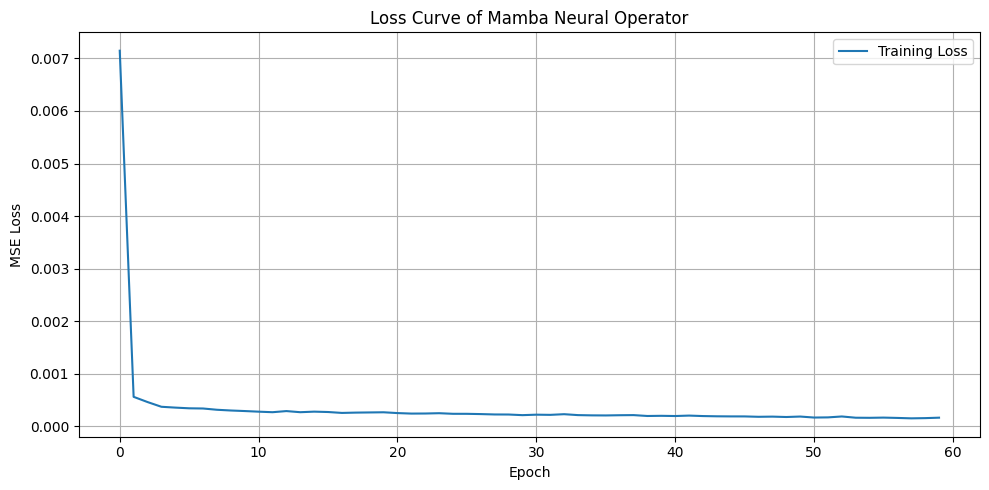

In [70]:
operator_model = EllipticOperator(depth=4).to("cuda")
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(operator_model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 60
loss_curve = []

for epoch in range(epochs):
    operator_model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        X_batch = X_batch.to("cuda")
        y_batch = y_batch.to("cuda")

        # Forward
        y_pred = operator_model(X_batch)

        # Loss
        loss = criterion(y_pred, y_batch)

        # Backprop and update
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_curve.append(avg_loss)

    if epoch % 5 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:03d} | Avg Loss: {avg_loss:.6f}")

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(loss_curve, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curve of Mamba Neural Operator")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Super-Résolution Test

### Visualisation of a sample 

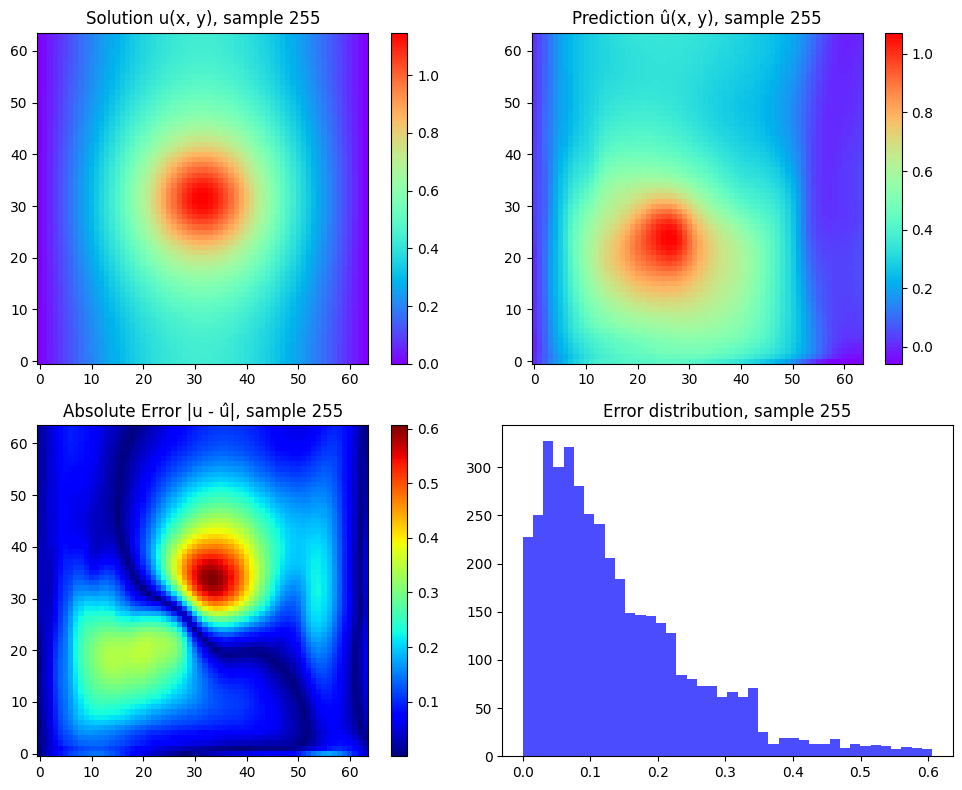

In [102]:
i = random.randint(0, 767)
# Loading data
k_test, u_solution = test_dataset1[60]   # No batch dimension
k_test = k_test.to("cuda").unsqueeze(0) # Add batch dimension: (1, H, W)
u_solution = u_solution.cpu().numpy()

# Inference
u_pred = operator_model(k_test)   # (1, H, W)
u_pred = u_pred.squeeze(0).cpu()  # (H, W)
u_pred = u_pred.detach().cpu().numpy()

# Error map
error_map = np.abs(u_pred - u_solution)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Ground Truth
im0 = axs[0, 0].imshow(u_solution, origin="lower", cmap="rainbow")
axs[0, 0].set_title(f"Solution u(x, y), sample {i+1}")
plt.colorbar(im0, ax=axs[0, 0])

# Prediction
im1 = axs[0, 1].imshow(u_pred, origin="lower", cmap="rainbow")
axs[0, 1].set_title(f"Prediction û(x, y), sample {i+1}")
plt.colorbar(im1, ax=axs[0, 1])

# Error map
im2 = axs[1, 0].imshow(error_map, origin="lower", cmap="jet")
axs[1, 0].set_title(f"Absolute Error |u - û|, sample {i+1}")
plt.colorbar(im2, ax=axs[1, 0])


# Error Boxplot
#axs[1, 1].hist(error_map.ravel(), bins=40, color="blue", alpha=0.7)
#axs[1, 1].boxplot(error_map.ravel())
axs[1, 1].set_title(f"Error distribution, sample {i+1}")

plt.tight_layout()
plt.show()

### Error distribution across Test Dataset

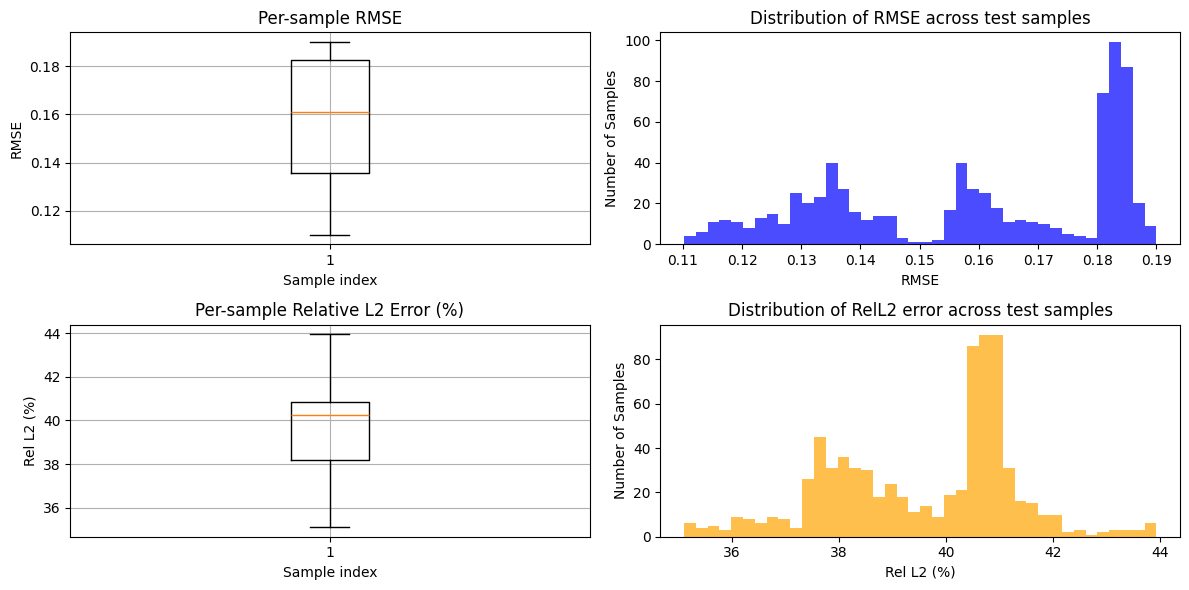

In [72]:
operator_model.eval()  
rmse_list = []
rel_l2_list = []

with torch.no_grad():
    for kappa, solution in test_loader1:
        kappa = kappa.to("cuda") # Adding batch dimension, shape goes from (H, W) to (1, H, W)             
        prediction = operator_model(kappa) 

        # Computing errors           
        solution = solution.cpu()
        prediction = prediction.cpu()
        
        error = (solution - prediction).numpy()
        solution = solution.numpy()
        prediction = prediction.numpy()

        # RMSE
        rmse = np.sqrt(np.mean((error)**2))
        rmse_list.append(rmse)

        # Relative L2 (%)
        rel_l2 = np.linalg.norm(error) / np.linalg.norm(solution)
        rel_l2_list.append(rel_l2 * 100)   

# Convert to numpy arrays
rmse_arr = np.array(rmse_list)
rel_l2_arr = np.array(rel_l2_list)   

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# --- RMSE ---
# Curve
axs[0, 0].boxplot(rmse_arr)
axs[0, 0].set_title("Per-sample RMSE")
axs[0, 0].set_xlabel("Sample index")
axs[0, 0].set_ylabel("RMSE")
axs[0, 0].grid(True)

# Histogram
axs[0, 1].hist(rmse_arr, bins=40, color="blue", alpha=0.7)
axs[0, 1].set_title("Distribution of RMSE across test samples")
axs[0, 1].set_xlabel("RMSE")
axs[0, 1].set_ylabel("Number of Samples")

# --- Relative L2 Error (%)
# Curve
axs[1, 0].boxplot(rel_l2_arr)
axs[1, 0].set_title("Per-sample Relative L2 Error (%)")
axs[1, 0].set_xlabel("Sample index")
axs[1, 0].set_ylabel("Rel L2 (%)")
axs[1, 0].grid(True)

# Histogram
axs[1, 1].hist(rel_l2_arr, bins=40, color="orange", alpha=0.7)
axs[1, 1].set_title("Distribution of RelL2 error across test samples")
axs[1, 1].set_xlabel("Rel L2 (%)")
axs[1, 1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()

# Generalization Test

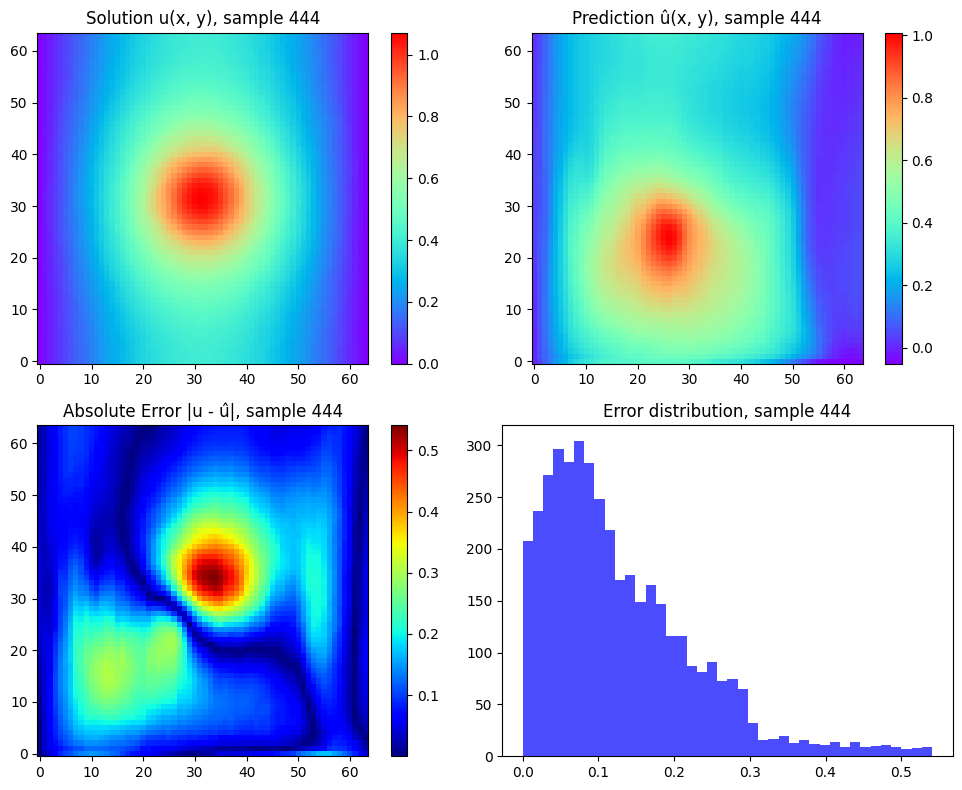

In [96]:
# Loading data
i = random.randint(0, 511)
k_test, u_solution = test_dataset2[0]   # No batch dimension
k_test = k_test.to("cuda").unsqueeze(0) # Add batch dimension: (1, H, W)
u_solution = u_solution.cpu().numpy()

# Inference
u_pred = operator_model(k_test)   # (1, H, W)
u_pred = u_pred.squeeze(0).cpu()  # (H, W)
u_pred = u_pred.detach().cpu().numpy()

# Error map
error_map = np.abs(u_pred - u_solution)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Ground Truth
im0 = axs[0, 0].imshow(u_solution, origin="lower", cmap="rainbow")
axs[0, 0].set_title(f"Solution u(x, y), sample {i+1}")
plt.colorbar(im0, ax=axs[0, 0])

# Prediction
im1 = axs[0, 1].imshow(u_pred, origin="lower", cmap="rainbow")
axs[0, 1].set_title(f"Prediction û(x, y), sample {i+1}")
plt.colorbar(im1, ax=axs[0, 1])

# Error map
im2 = axs[1, 0].imshow(error_map, origin="lower", cmap="jet")
axs[1, 0].set_title(f"Absolute Error |u - û|, sample {i+1}")
plt.colorbar(im2, ax=axs[1, 0])


# Error Boxplot
axs[1, 1].hist(error_map.ravel(), bins=40, color="blue", alpha=0.7)
#axs[1, 1].boxplot(error_map.ravel())
axs[1, 1].set_title(f"Error distribution, sample {i+1}")

plt.tight_layout()
plt.show()

## Error distribution across Test Dataset

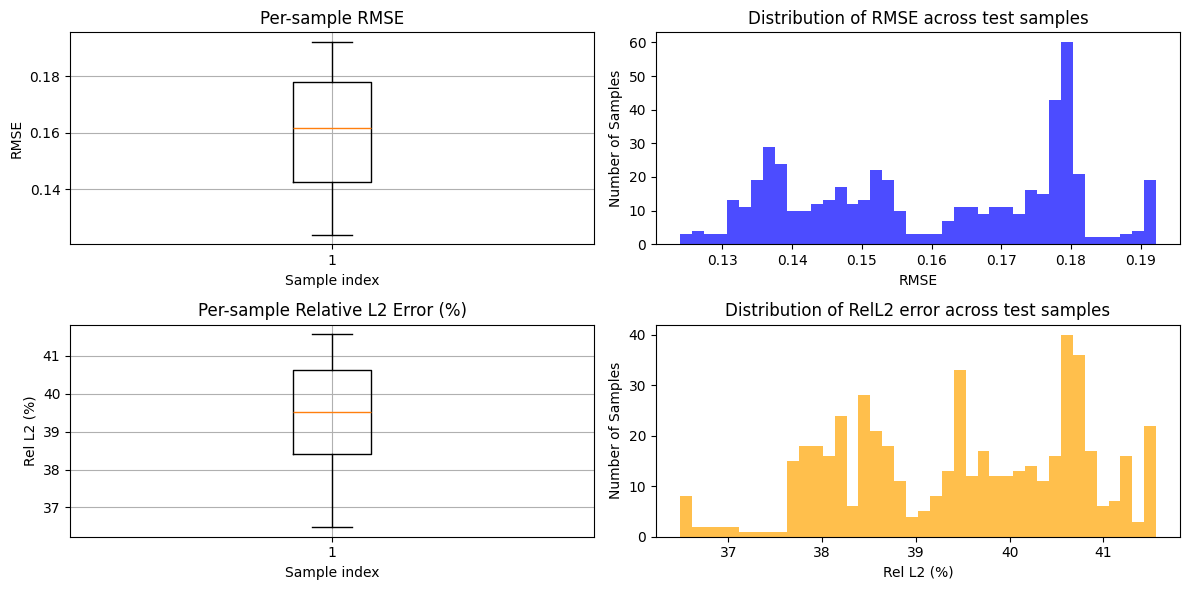

In [74]:
operator_model.eval()  
rmse_list = []
rel_l2_list = []

with torch.no_grad():
    for kappa, solution in test_loader2:
        kappa = kappa.to("cuda") # Adding batch dimension, shape goes from (H, W) to (1, H, W)             
        prediction = operator_model(kappa) 

        # Computing errors           
        solution = solution.cpu()
        prediction = prediction.cpu()
        
        error = (solution - prediction).numpy()
        solution = solution.numpy()
        prediction = prediction.numpy()

        # RMSE
        rmse = np.sqrt(np.mean((error)**2))
        rmse_list.append(rmse)

        # Relative L2 (%)
        rel_l2 = np.linalg.norm(error) / np.linalg.norm(solution)
        rel_l2_list.append(rel_l2 * 100)   

# Convert to numpy arrays
rmse_arr = np.array(rmse_list)
rel_l2_arr = np.array(rel_l2_list)   

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# --- RMSE ---
axs[0, 0].boxplot(rmse_arr)
axs[0, 0].set_title("Per-sample RMSE")
axs[0, 0].set_xlabel("Sample index")
axs[0, 0].set_ylabel("RMSE")
axs[0, 0].grid(True)

# Histogram
axs[0, 1].hist(rmse_arr, bins=40, color="blue", alpha=0.7)
axs[0, 1].set_title("Distribution of RMSE across test samples")
axs[0, 1].set_xlabel("RMSE")
axs[0, 1].set_ylabel("Number of Samples")

# --- Relative L2 Error (%)
# Curve
axs[1, 0].boxplot(rel_l2_arr)
axs[1, 0].set_title("Per-sample Relative L2 Error (%)")
axs[1, 0].set_xlabel("Sample index")
axs[1, 0].set_ylabel("Rel L2 (%)")
axs[1, 0].grid(True)

# Histogram
axs[1, 1].hist(rel_l2_arr, bins=40, color="orange", alpha=0.7)
axs[1, 1].set_title("Distribution of RelL2 error across test samples")
axs[1, 1].set_xlabel("Rel L2 (%)")
axs[1, 1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()